In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
forecasting = 20

In [4]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [5]:
df = df.drop(['MeasuredDate','CellNo'],axis=1)
df

,Resistance,Volt,Temp
0,0.259,2.23,-20
1,0.260,2.23,-20
2,0.259,2.23,-20
3,0.259,2.23,-20
4,0.259,2.23,-20
...,...,...,...
254,0.301,2.23,-20
255,0.301,2.23,-20
256,0.302,2.23,-20
257,0.300,2.23,-20


<AxesSubplot:>

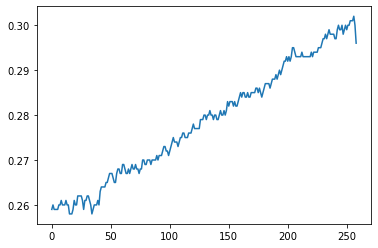

In [6]:
df['Resistance'].plot()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance','Volt','Temp']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [8]:
train = df_scaled

In [9]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [10]:
feature_cols = ['Volt','Temp','Resistance']
label_cols = ['Volt','Temp','Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [11]:
x_train.shape

(191, 20, 3)

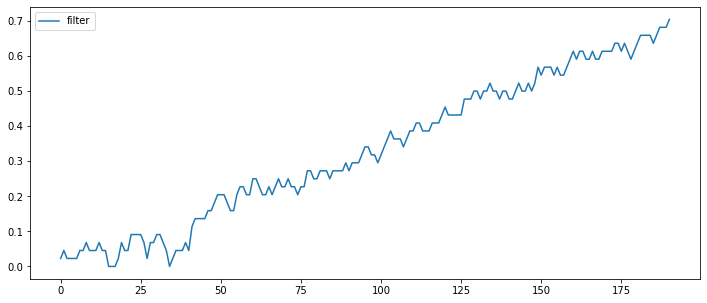

In [12]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,2],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

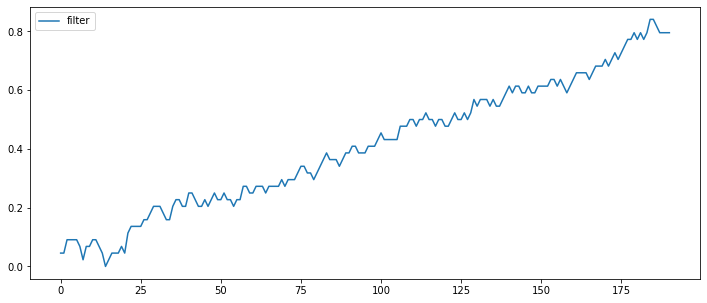

In [13]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,2],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [14]:
OUT_STEPS = 20

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*3))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 3]))

In [21]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', '210707noKFLSTMcell013Featuresmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=100, 
                    batch_size=4)

Epoch 1/100
48/48 [==============================] - 2s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0284
Epoch 2/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0276
Epoch 3/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0257
Epoch 4/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_error: 0.0307
Epoch 5/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0256
Epoch 6/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0288A: 0s - loss: 0.0054 - mean_absolute_error: 0.028
Epoch 7/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0268
Epoch 8/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0298
Epoch 9/100
48/48 [==============================] - 0s 7ms/step - loss

48/48 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_absolute_error: 0.0199
Epoch 74/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0183
Epoch 75/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0210
Epoch 76/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0185
Epoch 77/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0183
Epoch 78/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0168
Epoch 79/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0186
Epoch 80/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0164
Epoch 81/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0163
Epoch 82/100
4

num 0 148.0313970492438 actual 0.6190476190476186 prediction 1.5354325
num 1 39.85655009746546 actual 0.6666666666666661 prediction 0.40095633
num 2 100.09807050228119 actual 0.7142857142857135 prediction -0.0007005036
num 3 3.3665247261525275 actual 0.7619047619047628 prediction 0.73625505
num 4 18.54052186012281 actual 0.7142857142857135 prediction 0.846718
num 5 123.26704114675525 actual 0.6666666666666661 prediction -0.15511361
num 6 130.14018535614034 actual 0.6666666666666661 prediction 1.5342679
num 7 75.72520822286603 actual 0.6666666666666661 prediction 0.16183195
num 8 29.89431500434868 actual 0.7142857142857135 prediction 0.5007549
num 9 135.9838223457339 actual 0.7142857142857135 prediction 1.6855987
num 10 130.22326558828357 actual 0.7142857142857135 prediction -0.21588047
num 11 234.25649404525788 actual 0.6666666666666661 prediction 2.2283766
num 12 9.66500520706167 actual 0.7142857142857135 prediction 0.64524996
num 13 21.017341315746172 actual 0.7619047619047628 predic

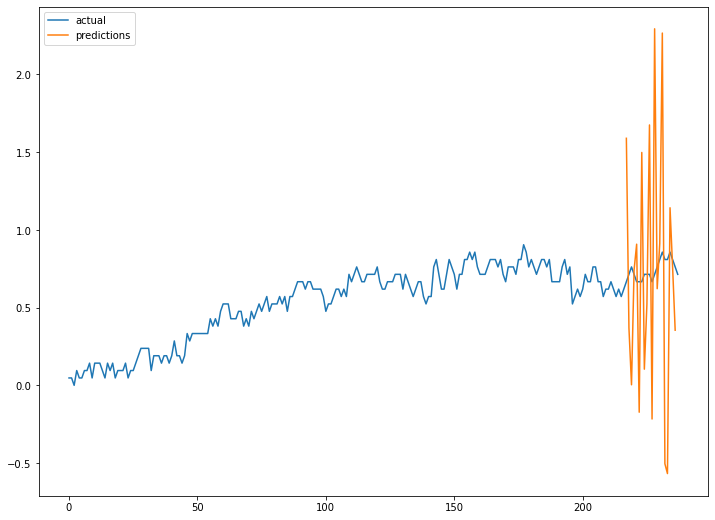

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 187.82322066170835 actual 0.8006535947712417 prediction 2.304467
num 1 38.34303261772279 actual 0.8104575163398693 prediction 0.49970353
num 2 103.61280630690506 actual 0.8137254901960784 prediction -0.029398326
num 3 27.938093757629396 actual 0.8169934640522876 prediction 0.58874106
num 4 89.08329181671142 actual 0.8169934640522876 prediction 1.5447981
num 5 148.44381429284692 actual 0.8202614379084967 prediction -0.39736593
num 6 65.60408475370747 actual 0.826797385620915 prediction 1.3692102
num 7 139.12453171797097 actual 0.8366013071895424 prediction -0.32731634
num 8 31.434406368888933 actual 0.8464052287581698 prediction 0.58034277
num 9 110.1767679740643 actual 0.8529411764705881 prediction 1.7926842
num 10 114.268579676804 actual 0.8594771241830064 prediction -0.12263518
num 11 259.3862078406595 actual 0.8627450980392155 prediction 3.100587
num 12 36.21943644757539 actual 0.8660130718954246 prediction 0.552348
num 13 32.819774195833055 actual 0.8660130718954246 predictio

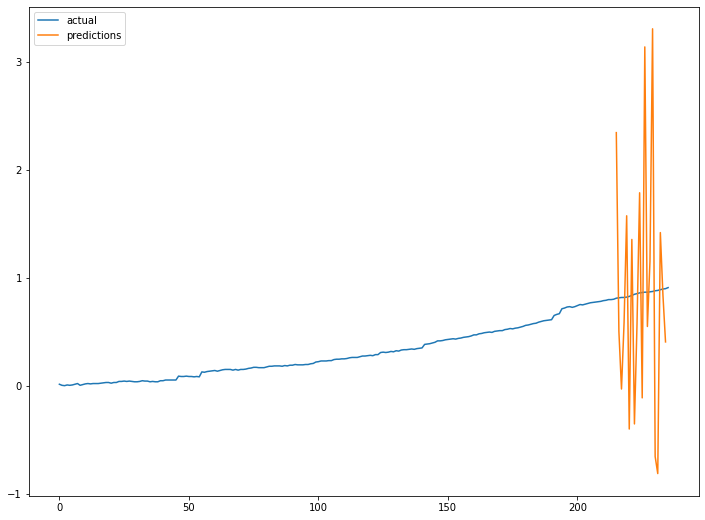

In [28]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 146.29073377741813 actual 0.6762402088772845 prediction 1.665517
num 1 34.747555208477095 actual 0.6892950391644908 prediction 0.44978186
num 2 103.58635318720162 actual 0.6971279373368144 prediction -0.02500147
num 3 2.3577718486572956 actual 0.702349869451697 prediction 0.68579006
num 4 43.941266290376134 actual 0.7075718015665795 prediction 1.0184878
num 5 132.82936280661255 actual 0.7154046997389034 prediction -0.2348628
num 6 112.2683257185003 actual 0.7284595300261096 prediction 1.5462888
num 7 89.34259992553572 actual 0.7389033942558747 prediction 0.07874789
num 8 23.221236986565657 actual 0.7493472584856395 prediction 0.57533956
num 9 133.46836665922385 actual 0.7545691906005221 prediction 1.7616804
num 10 129.43193824523138 actual 0.7650130548302871 prediction -0.22515817
num 11 214.58002312653724 actual 0.7676240208877285 prediction 2.4147918
num 12 18.413889002637802 actual 0.7676240208877285 prediction 0.6262746
num 13 30.523212164040398 actual 0.7780678851174934 pred

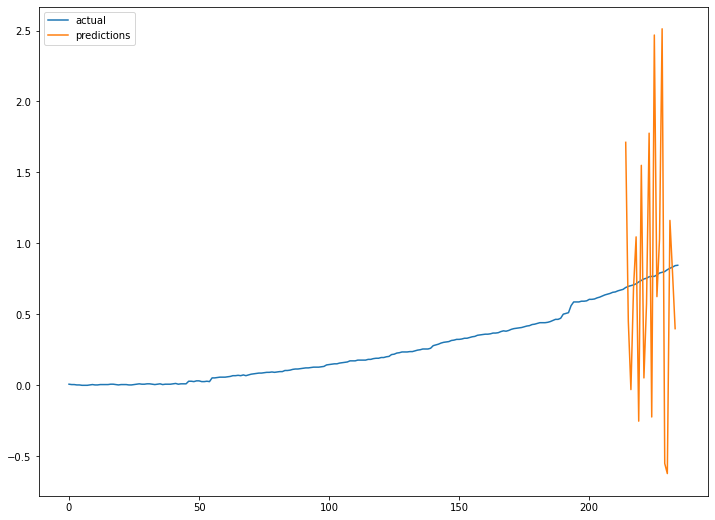

In [29]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 195.81923233835343 actual 0.7916666666666661 prediction 2.3419023
num 1 44.79299720964929 actual 0.7916666666666661 prediction 0.43705544
num 2 97.51899195344824 actual 0.7916666666666661 prediction 0.019641314
num 3 21.211989720662437 actual 0.75 prediction 0.5909101
num 4 92.71218149285582 actual 0.7916666666666661 prediction 1.5256381
num 5 157.33987887700397 actual 0.75 prediction -0.4300491
num 6 55.99382877349842 actual 0.8333333333333339 prediction 1.2999486
num 7 132.89783000946042 actual 0.8333333333333339 prediction -0.27414858
num 8 46.534295515580574 actual 0.9166666666666661 prediction 0.4901023
num 9 78.95626399828029 actual 0.9583333333333339 prediction 1.7149975
num 10 113.51182616275288 actual 0.9583333333333339 prediction -0.12948833
num 11 223.9600720612897 actual 0.9583333333333339 prediction 3.1046174
num 12 42.78293070585835 actual 0.9583333333333339 prediction 0.54833025
num 13 11.008212877356419 actual 0.9583333333333339 prediction 1.0638287
num 14 251.467

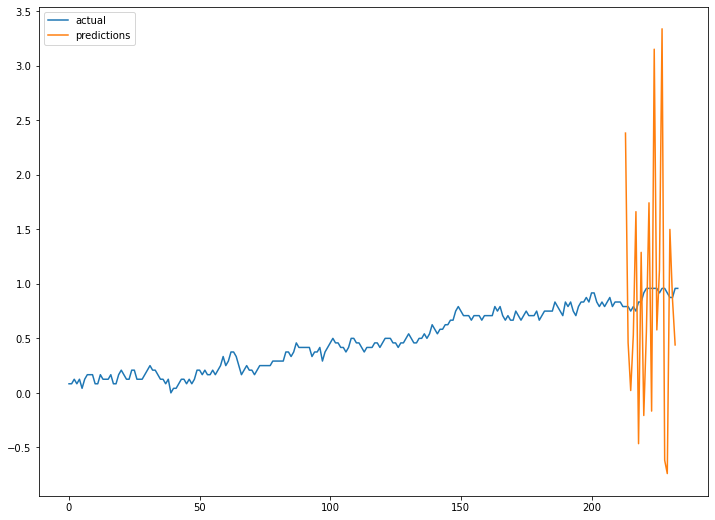

In [30]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 205.18936157226565 actual 0.8482142857142856 prediction 2.5886598
num 1 40.35554130872088 actual 0.8571428571428568 prediction 0.5112382
num 2 102.01101020762795 actual 0.8482142857142856 prediction -0.017057676
num 3 35.64407188854914 actual 0.8526785714285712 prediction 0.5487492
num 4 104.3623776779962 actual 0.8660714285714284 prediction 1.7699242
num 5 150.01251016344344 actual 0.875 prediction -0.43760946
num 6 41.53463489513109 actual 0.8794642857142856 prediction 1.2447466
num 7 153.6481339727814 actual 0.8883928571428568 prediction -0.4766062
num 8 38.21484729497118 actual 0.8839285714285712 prediction 0.5461366
num 9 94.9653817181612 actual 0.8883928571428568 prediction 1.7320585
num 10 107.3202112708429 actual 0.8839285714285712 prediction -0.06470544
num 11 275.2647705078125 actual 0.8928571428571428 prediction 3.3505783
num 12 42.29760594887306 actual 0.901785714285714 prediction 0.52035195
num 13 26.57833757071659 actual 0.90625 prediction 1.1471162
num 14 290.54891

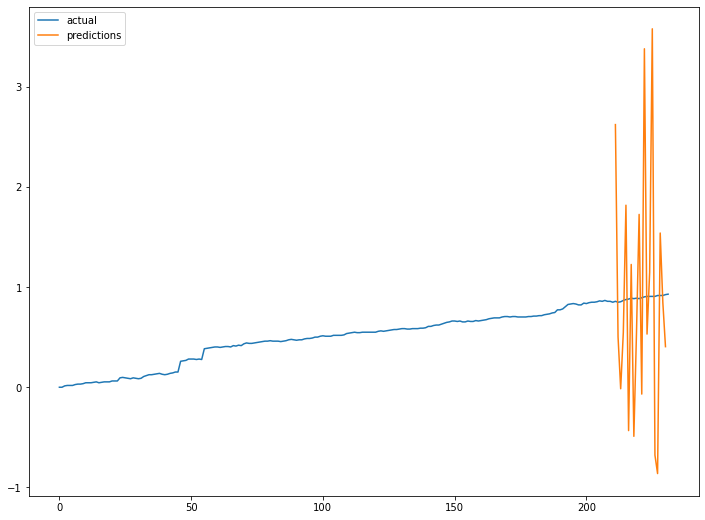

In [31]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 79.10584281472569 actual 0.8500000000000014 prediction 1.5223997
num 1 42.44157150387769 actual 0.8000000000000007 prediction 0.46046743
num 2 96.54644305507341 actual 0.75 prediction 0.025901677
num 3 1.419234275817871 actual 0.75 prediction 0.76064426
num 4 27.199300130208332 actual 0.75 prediction 0.95399475
num 5 125.0155508518219 actual 0.75 prediction -0.18761663
num 6 117.86751065935374 actual 0.7000000000000011 prediction 1.5250726
num 7 63.629790714808934 actual 0.7000000000000011 prediction 0.25459146
num 8 14.084177750807589 actual 0.6500000000000004 prediction 0.55845284
num 9 133.15853731972794 actual 0.7000000000000011 prediction 1.6321098
num 10 140.20005067189533 actual 0.75 prediction -0.30150038
num 11 186.77902221679688 actual 0.75 prediction 2.1508427
num 12 16.20781591960375 actual 0.7000000000000011 prediction 0.5865453
num 13 20.128469807760872 actual 0.7000000000000011 prediction 0.8408993
num 14 166.75736904144262 actual 0.8000000000000007 prediction 2.13

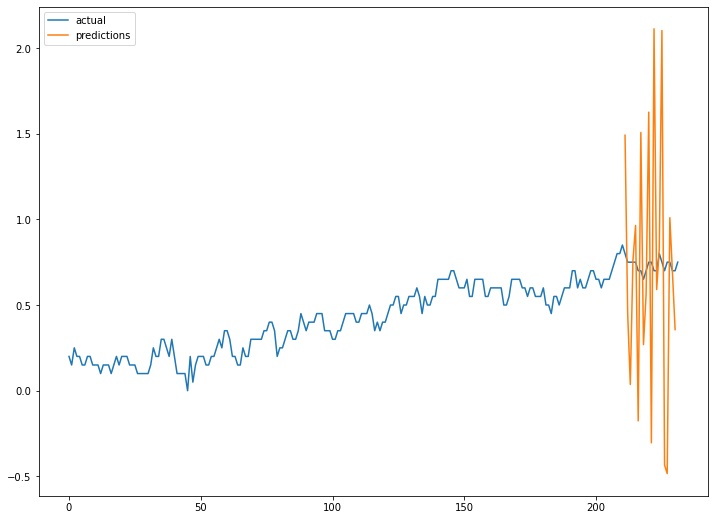

In [32]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 190.09057432413135 actual 0.8421052631578938 prediction 2.442868
num 1 42.22966721563627 actual 0.8684210526315788 prediction 0.50168973
num 2 104.92935727816075 actual 0.8421052631578938 prediction -0.041510377
num 3 31.33158178040474 actual 0.8684210526315788 prediction 0.596331
num 4 86.06747641707916 actual 0.8684210526315788 prediction 1.6158491
num 5 150.45745484530931 actual 0.8421052631578938 prediction -0.42490488
num 6 68.15718912309232 actual 0.8157894736842097 prediction 1.3718086
num 7 147.45073895300592 actual 0.8157894736842097 prediction -0.38709813
num 8 34.61463004350655 actual 0.8421052631578938 prediction 0.55061364
num 9 113.48238736391092 actual 0.8421052631578938 prediction 1.7977464
num 10 113.30324424938722 actual 0.8684210526315788 prediction -0.115528174
num 11 282.0529237389569 actual 0.8421052631578938 prediction 3.2172878
num 12 36.971399713965 actual 0.8947368421052628 prediction 0.5639401
num 13 34.69780936385649 actual 0.8684210526315788 predictio

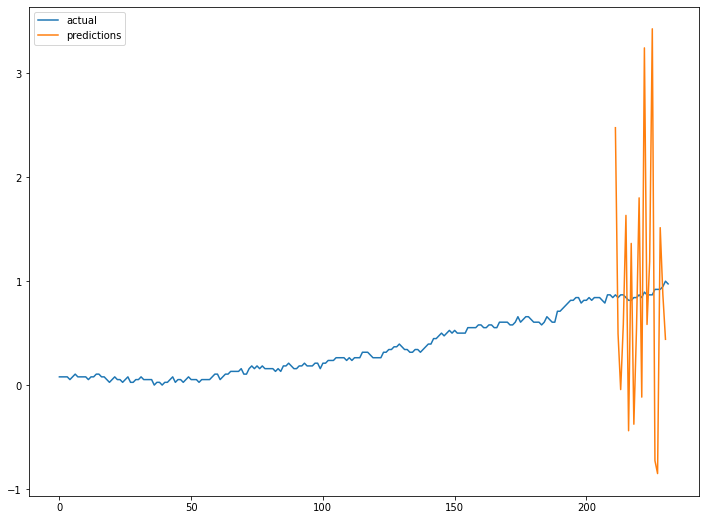

In [33]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 135.92738151550267 actual 0.76923076923077 prediction 1.814826
num 1 32.154342375303656 actual 0.7307692307692317 prediction 0.4957952
num 2 101.45143278335269 actual 0.7307692307692317 prediction -0.010606624
num 3 10.27859010194489 actual 0.7307692307692317 prediction 0.65565646
num 4 62.17090818617095 actual 0.6923076923076916 prediction 1.1227217
num 5 143.18664193153376 actual 0.76923076923077 prediction -0.33220494
num 6 95.50608566829119 actual 0.8076923076923084 prediction 1.5790876
num 7 82.39606320858003 actual 0.8076923076923084 prediction 0.14218564
num 8 38.610784573988525 actual 0.8461538461538467 prediction 0.5194472
num 9 119.02429376329675 actual 0.8076923076923084 prediction 1.7690424
num 10 133.666099011898 actual 0.76923076923077 prediction -0.25897
num 11 230.53650140762292 actual 0.76923076923077 prediction 2.5425885
num 12 18.392936587333768 actual 0.76923076923077 prediction 0.62774664
num 13 28.13294955662308 actual 0.8076923076923084 prediction 1.03492
n

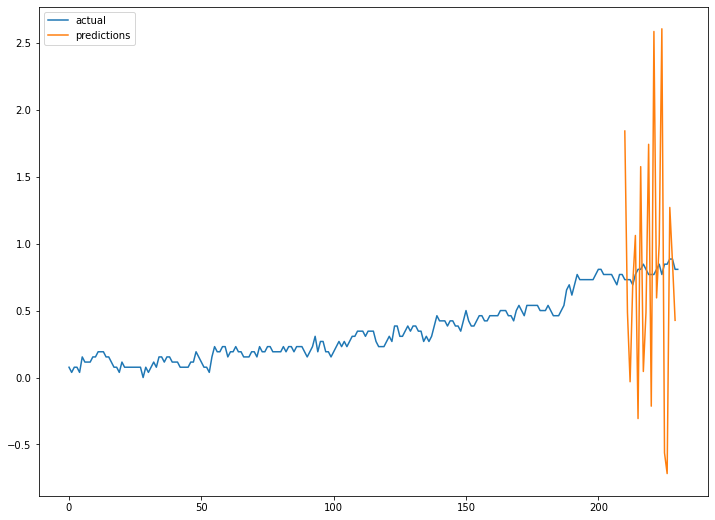

In [34]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 159.98080293337514 actual 0.7389162561576352 prediction 1.9210404
num 1 37.8704432005945 actual 0.7487684729064039 prediction 0.46520653
num 2 102.46727349954882 actual 0.7536945812807878 prediction -0.018595707
num 3 13.190803202715756 actual 0.7586206896551722 prediction 0.6585525
num 4 57.660921873190475 actual 0.7684729064039408 prediction 1.2115815
num 5 143.98930889026374 actual 0.7733990147783252 prediction -0.34021288
num 6 94.58494065683107 actual 0.7783251231527091 prediction 1.5145035
num 7 106.20995617981228 actual 0.7832512315270934 prediction -0.04863956
num 8 26.668865419924252 actual 0.7881773399014778 prediction 0.5779794
num 9 126.60061794778574 actual 0.7931034482758621 prediction 1.7971773
num 10 127.60323494856742 actual 0.798029556650246 prediction -0.22028197
num 11 236.8156730392834 actual 0.798029556650246 prediction 2.6878886
num 12 26.433201715713583 actual 0.8078817733990147 prediction 0.59433275
num 13 29.94816660167218 actual 0.8226600985221673 predi

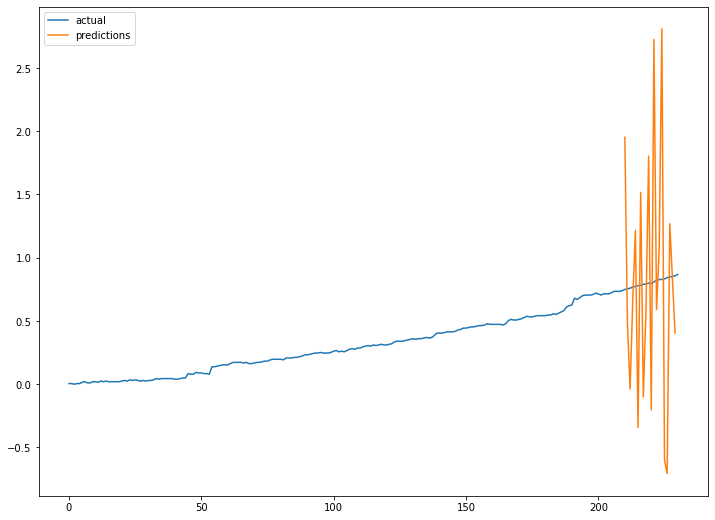

In [35]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

x_test2 = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()